In [9]:
#Questions:
#what are functionalities in ipython display
#ipywidgest?
#os? os.walk()?
#unique()
#RMSSE
#consistency: try to install everything with pip or conda
#pd.index can be applied in time series analysis to indexing each column
#melt function is to reorganize rows and columns in a desired, meaningful way. Reduction of columns and change into row layout
# def series_from_id(_id:str) -> pd.DataFrame:
#pd.agg provides row summerizatons
#pd.df.loc  can take a column name or [row:column] slicing 
#pivot table
#copy: make a copy of the original dataframe
#are there any randomness involved in normalization?

In [10]:
%cd '/Users/xiaoyingliu/desktop/walmart_uncertainty'

/Users/xiaoyingliu/Desktop/walmart_uncertainty


In [11]:
#Competition data file introduction:
# 1. calendar.csv information about the dates on which the products are sold
# 2. sales_train_validation.csv historical unit sales data per product and store[d_1-d_1913]
# 3.sample_submission.csv correct format for submissions
# 4. sell_prices.csv price of the products sold per store and date
# 5.sales_train_evaluation.csv evaluation dataset

# Target goal: predicting item sales at stores in various locations for two 28-day time periods
# Evaluation: RMSSE

In [12]:
#The M5 dataset is a set of time series of daily sales with a heirarchical structure:
# A category has multiple departments
# a departments spans across multiple stores
# a department contains multiple items
# a combination of item and store is a most granular level of series. 
# We will need to do transfer learning between series

In [13]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from random import sample
import random
import itertools
import sklearn
%matplotlib inline
from dtw import * 
#here dtw works only with a rolling back version of numpy 1.16.1

In [14]:
#Load data
sales=pd.read_csv('sales_train_validation.csv')
sales.loc[sales.item_id=='HOBBIES_1_001'].sort_values('id').head()
#Each item in multiple rows, once for each of the stores its sold in
#The actual time series are stored in wide format, the series are stored in columns ranging from 1 to 1913,indicating the days since the start of
#the time period in question

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
3049,HOBBIES_1_001_CA_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,0,0,0,0,...,0,0,1,2,0,4,0,0,2,2
6098,HOBBIES_1_001_CA_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,2,4,0,1,1,1,0,3,3
9147,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,0,0,0,0,...,1,0,0,1,0,1,0,1,2,1
12196,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2


In [15]:
#make time series columns integars for more meaningful plotting
_cols=list(sales.columns)
sales.columns=pd.Index(_cols[:6]+[int(c.replace('d_','')) for c in _cols[6:]])

In [16]:
del _cols

In [17]:
#isolating functions
#get a daily time series for a single id
def series_from_id(_id:str) -> pd.DataFrame:
    return sales.loc[sales.id==_id].iloc[:,6:].T    

In [18]:
#creating a global lookup table for fast plotting by department(sql)
daily_sales_dept_lookup=sales[['dept_id']+list(sales.columns[6:])].melt(id_vars='dept_id').groupby('dept_id variable'.split()).agg({'value':'sum'})

In [19]:
def series_from_dept(dept:str)->pd.DataFrame:
    return daily_sales_dept_lookup.loc[dept] 

In [20]:
#creating a global lookup table for fast plotting by item
daily_sales_item_lookup=sales[['item_id']+list(sales.columns[6:])].melt(id_vars='item_id').groupby('item_id variable'.split()).agg({'value':'sum'})

In [21]:
def series_from_item(item:str)->pd.DataFrame:
    return daily_sales_item_lookup.loc[item]

In [39]:
#time series for particular items are quite noisy on a daily level. 
#Provide weekly bin sales for more stable plots
def series_from_id_binned(_id:str,bin_every:int=7)->pd.DataFrame:
    t=series_from_id(_id).reset_index()
    t['index']=t.index.map(lambda x:x -(x%bin_every))
    t.columns=pd.Index(['day','sales'])
    return t.groupby('day').agg({'sales':'sum'})

def series_from_dept_binned(dept:str,bin_every:int=7)->pd.DataFrame:
    t=series_from_dept(dept).reset_index()
    t['variable']=t.index.map(lambda x:x -(x%bin_every))
    return t.groupby('variable').agg({'value':'sum'})

def series_from_item_binned(item:str,bin_every:int=7)->pd.DataFrame:
    t=series_from_item(item).reset_index()
    t['variabel']=t.index.map(lambda x:x -(x%bin_every))
    return t.groupby('variable').agg({'value':'sum'})

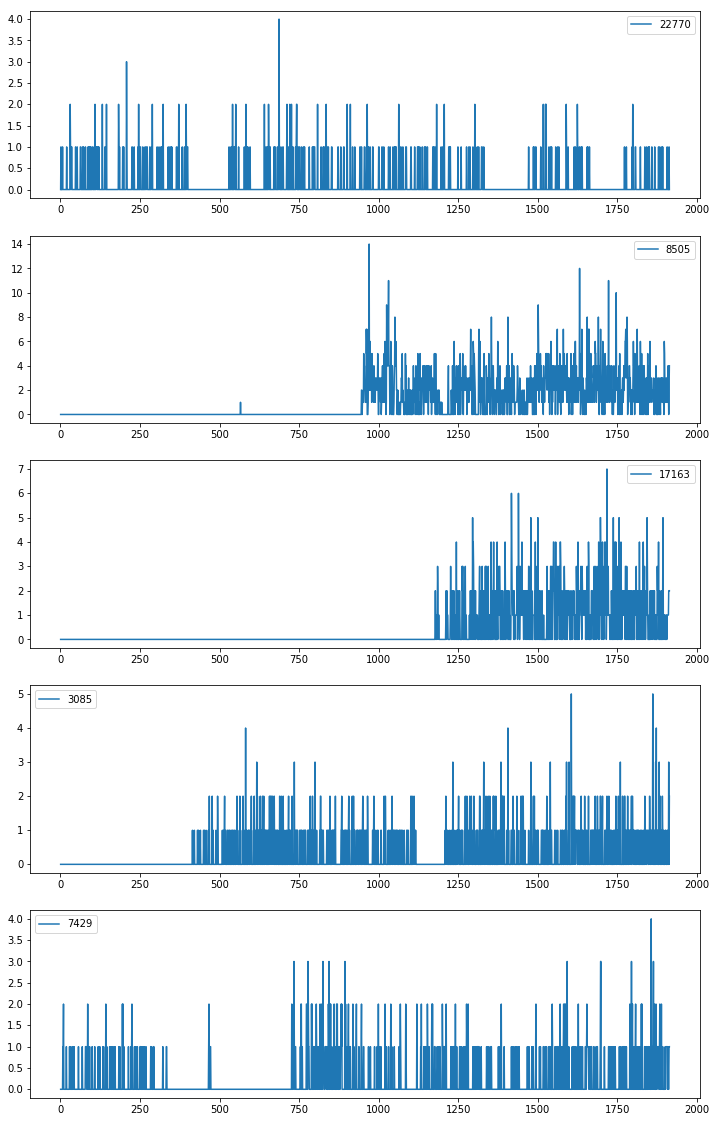

In [32]:
#plot 5 unique items(id)
fig,axes=plt.subplots(nrows=5,figsize=(12,20)) #5 plots in a row
_ids=sales['id'].sample(n=5,random_state=1)
for i in range(len(_ids)):
    series_from_id(_ids.iloc[i]).plot(ax=axes[i])
del _ids

In [ ]:
#We see differences in the series shapes, some have traffic all throughout while others don't start until later on
#y-axis scale is different

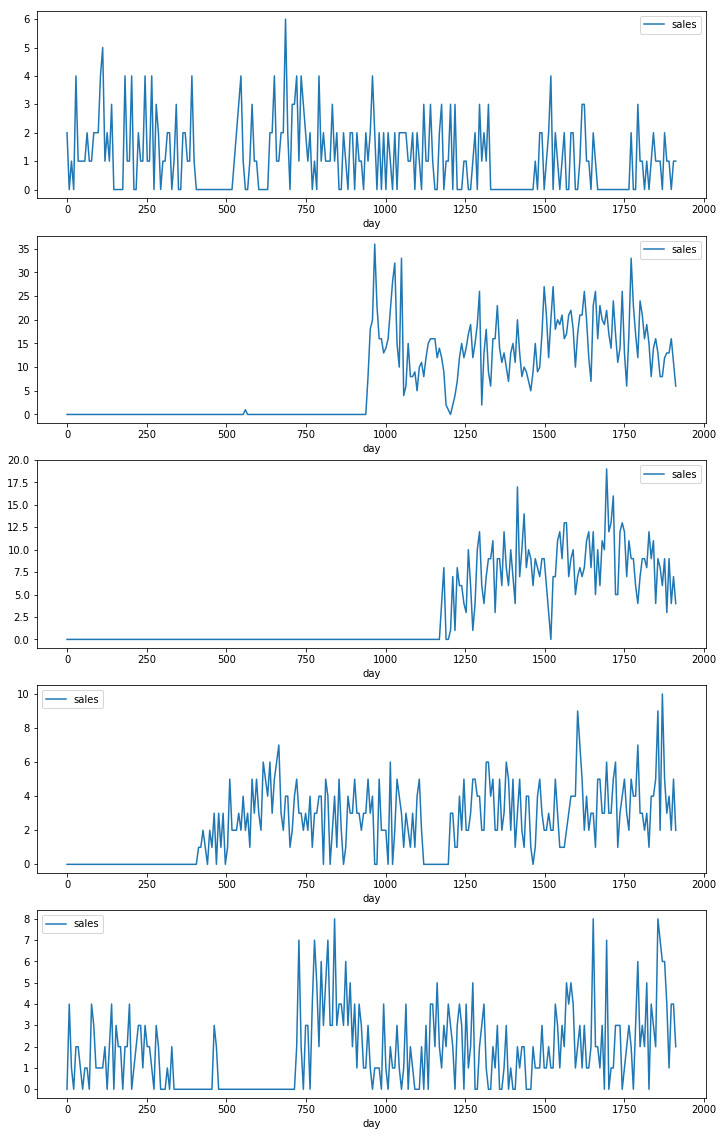

In [40]:
#bin the sales by week to remove weekly seasonality
fig,axes=plt.subplots(nrows=5,figsize=(12,20))
_ids=sales['id'].sample(n=5,random_state=1)
for i in range(len(_ids)):
    series_from_id_binned(_ids.iloc[i],bin_every=7).plot(ax=axes[i])

In [ ]:
#For some plots,sales start at a certain point, and then they are quite strong. This is probably because these items were introduced
#Real signal with a period of zero sales, we need to way to clip the beginning of the series that has no sales, and only start training after points
#that we have data

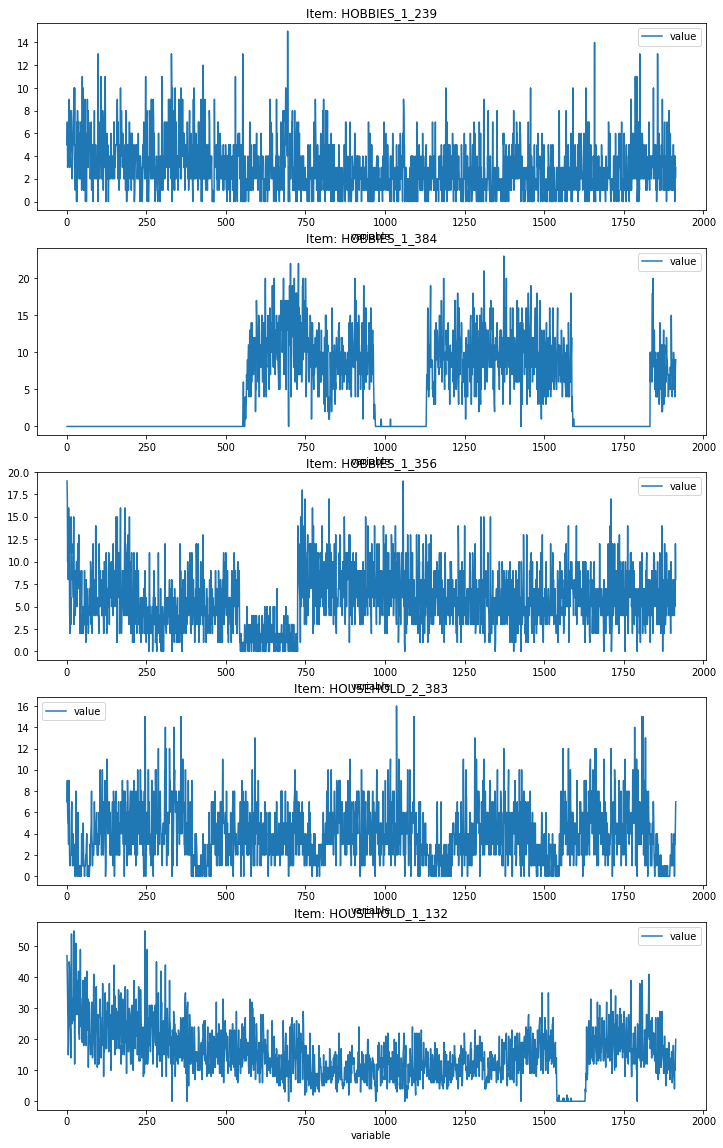

In [41]:
#Item plots
fig,axes=plt.subplots(nrows=5,figsize=(12,20))
random.seed(2)
_ids=sample(list(sales['item_id'].unique()),5)
for i in range(len(_ids)):
    series_from_item_binned(_ids[i],bin_every=7).plot(ax=axes[i])
    axes[i].set_title('Item: %s' % _ids[i])


In [ ]:
#As sales change all of sudden quite dramatically, its'clear that some interventions that walmart makes. For example, it looks like after months of 
#steady sales, maybe because they are taken off shelves at one or more time. 
#the last chart shows that an item may be introduced and then removed from the shelves on a periodic basis. 

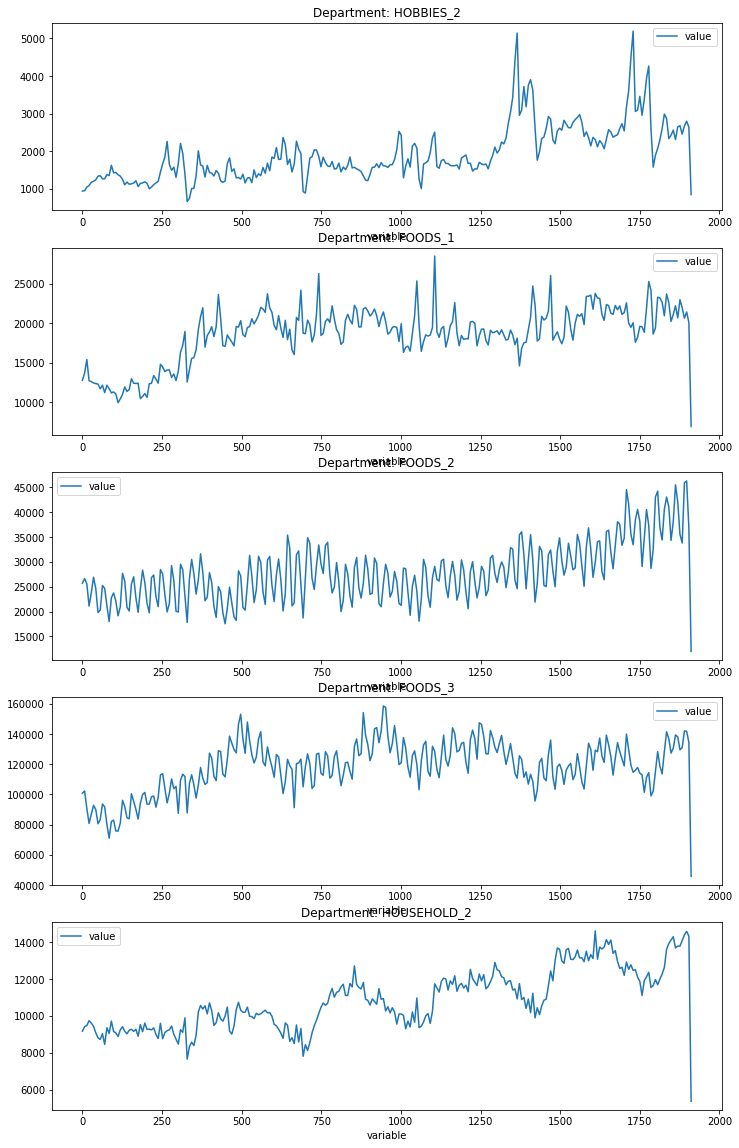

In [48]:
#departments plots
fig,axes=plt.subplots(nrows=5, figsize=(12,20))
random.seed(3)
_ids=sample(list(sales['dept_id'].unique()),5)
for i in range(len(_ids)):
    series_from_dept_binned(_ids[i],bin_every=7).plot(ax=axes[i])
    axes[i].set_title('Department: %s' % _ids[i])

In [ ]:
#At department level, this seems like a time series which are more stright forward to work with. Clear trend, seasonality and periodic components. 
#We can use parametric time series model(S-ARIMA), or a quantile regression

In [ ]:
#Clustering on item level
#1. granularity pick: should be useful and at the same time not subject to too much noise
#2. department clustering: No need to cluster departments, since there are only 7 departments and could probably be forecasted individually. 
#3. item clustering. we need to understand which items are similar, in terms of demand and how walmart changes. 
#4. weekly seasonality. I am going to group by week, which impliciitly assumes that all items have similar weekly seasonality. 

In [ ]:
#Rescaling series:
#some items are sold at a way higher rate than others, when we cluster, we do not want the result of clustering to split popular vs unpopular items. 
#will rescale each item according to its global mean. 

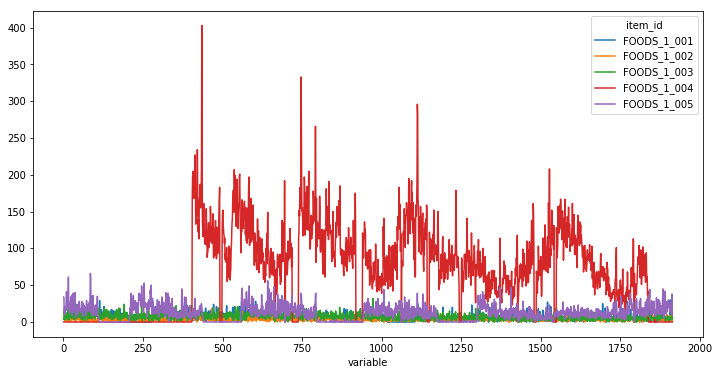

In [49]:
#plotting 10 series, for demonstration
daily_sales_item_lookup.pivot_table(index='variable',columns='item_id',values='value').iloc[:,:5].plot(figsize=(12,6))

In [22]:
#create a lookup table for scaled series
daily_sales_item_lookup_scaled=daily_sales_item_lookup.pivot_table(index='variable',columns='item_id',values='value').copy()
daily_sales_item_lookup_scaled=daily_sales_item_lookup_scaled.div(daily_sales_item_lookup_scaled.mean(axis=0),axis=1)

In [23]:
#bin by week
daily_sales_item_lookup_scaled_weekly=daily_sales_item_lookup_scaled.copy().reset_index()
daily_sales_item_lookup_scaled_weekly['variable']=daily_sales_item_lookup_scaled_weekly.variable.map(lambda x:x-(x%7))
daily_sales_item_lookup_scaled_weekly=daily_sales_item_lookup_scaled_weekly.groupby('variable').mean()

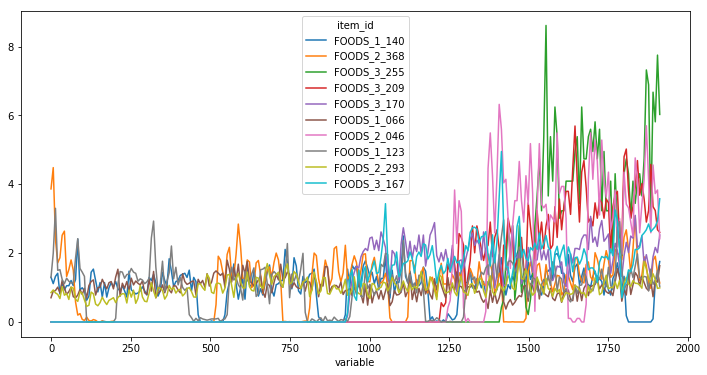

In [24]:
#plot series after normalization by series's means
random.seed(1)
daily_sales_item_lookup_scaled_weekly.iloc[:,random.sample(range(1000),10)].plot(figsize=(12,6))

In [ ]:
#now that we are scale invariant, we can focus on shape

In [ ]:
#Heirarchical clustering
#we treat each time series as a vector of the same length, and cluster them just as other vectors. we are grouping together series that behave similar
#at the same points in time. This method does not recognize shifts in otherwise similar series. 

In [25]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster,ward,dendrogram

In [27]:
#heirarachical clustering of scales weekly item sales. 
clf=AgglomerativeClustering(n_clusters=None,distance_threshold=0).fit(daily_sales_item_lookup_scaled_weekly.T.values)

In [34]:
#given a linkage model, plot dendrogram, with the colors indicated by the cutoff point at which we define clusters
def plot_dendrogram(model,**kwargs):
    #create linkage matrix and plot
    #creat coutnts of sample underr each node
    counts=np.zeros(model.children_.shape[0])
    n_samples=len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count=0
        for child_idx in merge:
             if child_idx<n_samples:
                current_count+=1 #leaf node
             else:
                current_count+=counts[child_idx-n_samples]
    counts[i]=current_count
    
    linkage_matrix=np.column_stack([model.children_,model.distances_,counts]).astype(float)
    
#plot the corresponding dendrogram
    dendrogram(linkage_matrix,**kwargs)
    return linkage_matrix                

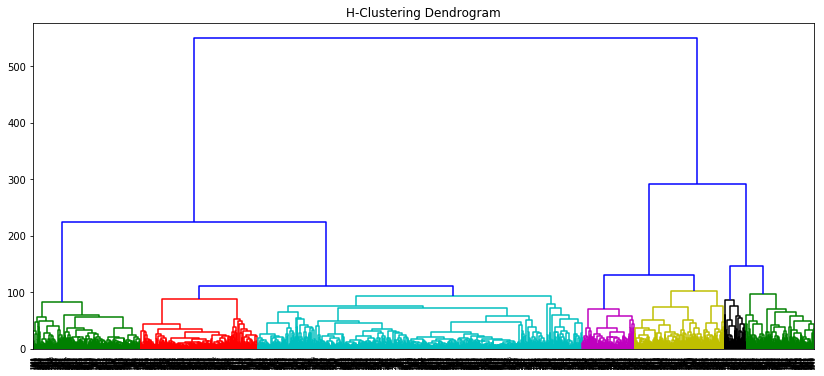

In [35]:
plt.figure(figsize=(14,6))
plt.title('H-Clustering Dendrogram')
#plot the top 5 levels of dendrogram
z=plot_dendrogram(clf,p=5,color_threshold=110)
plt.show()

In [37]:
#extract clusters from dendrogram
clusters=fcluster(z,100,criterion='distance')
#create a lookup table for series in a given cluster
daily_sales_item_lookup_scaled_clustered=daily_sales_item_lookup_scaled_weekly.T.reset_index()
daily_sales_item_lookup_scaled_clustered['cluster']=clusters 
daily_sales_item_lookup_scaled_clustered=daily_sales_item_lookup_scaled_clustered.set_index('cluster item_id'.split()).sort_index()

In [ ]:
#plot samples from different clusters and compare

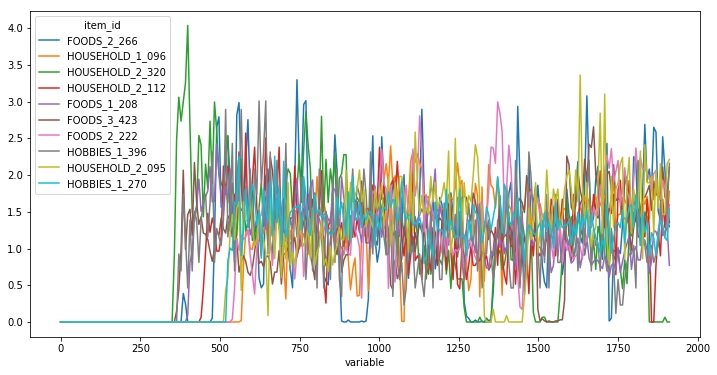

In [38]:
#cluster 1
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[1].T.iloc[:,random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[1].shape[0]),10)].plot(figsize=(12,6))
#it seems that they start very few sales up until day 300-500, and have relatively steady sales past that point. for data in cluster 1, pre-processing 
#could be similar that we can cut off the first 300 days of sale. 

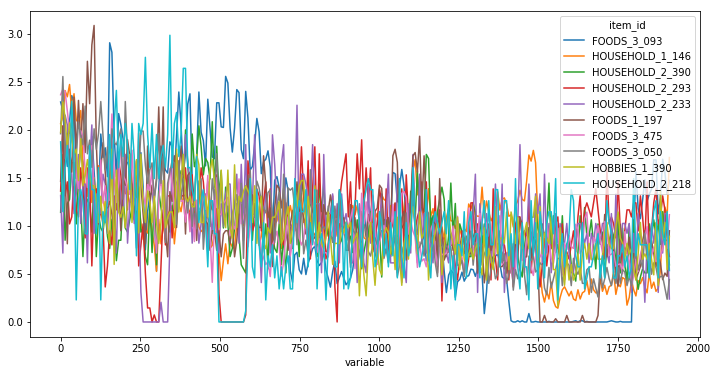

In [39]:
#cluster 2
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[2].T.iloc[:,random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[2].shape[0]),10)].plot(figsize=(12,6))
#shows a period of decreasing trend, then they stabalize around 700-1000 days into the time frame. 

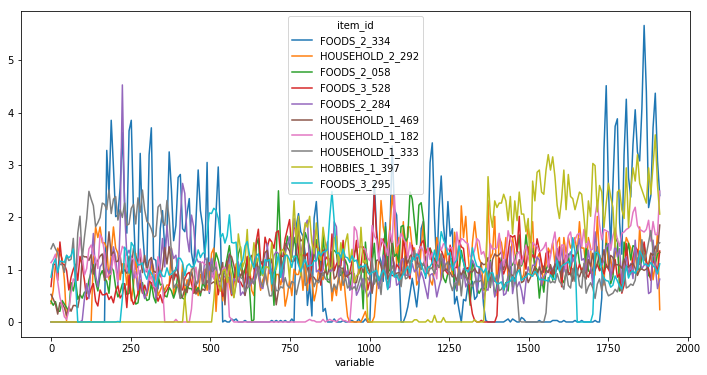

In [40]:
#cluster 3
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[3].T.iloc[:,random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[3].shape[0]),10)].plot(figsize=(12,6))
#this cluster does not tell a clear story since in the dendrogram, this cluster is the widest, meaning that the series in this cluster are not found 
#to be very well grouped together. 

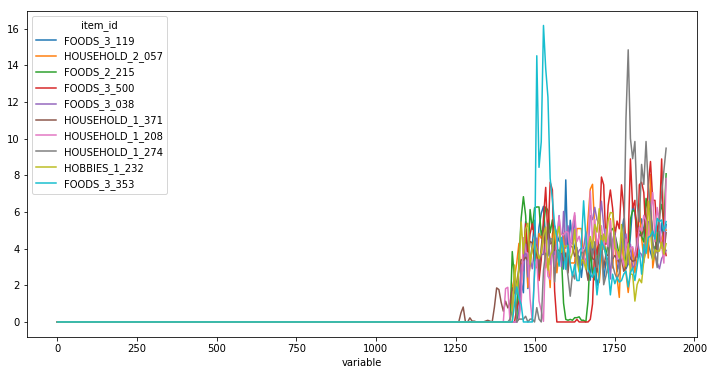

In [41]:
#cluster 7
random.seed(1)
daily_sales_item_lookup_scaled_clustered.loc[7].T.iloc[:,random.sample(range(daily_sales_item_lookup_scaled_clustered.loc[7].shape[0]),10)].plot(figsize=(12,6))
#sales pick up around 1300-1500 days into the time period, pre-processing could be cut off at 1300 datapoints, since no signals to be learnt before 1300 days 

In [ ]:
#conclusion: heirachical clustering is blind to similarities with shift. To address such similarities, we use dynamic time warping. 

In [ ]:
#Dynamic time warping(DTW)
#instead of using Euclidean distance to compare series, we use a normalized DTW distance. 
#DTW has a quadratic time complexity in the size of each vector. if there are m items in dataset each with n elements. then the time to compute a full
#distance matrix between the series in the dataset is O(m^2n^2)


In [42]:
#define a func to compute a distance matrix by computing the DTW distance of all pairwise combinations of series. 
def get_dtw_diff_matrix(cols:list):
    diff_matrix={}
    cross=itertools.product(cols,cols)
    for(col1,col2) in cross:
        series1=daily_sales_item_lookup_scaled_weekly[col1]
        series2=daily_sales_item_lookup_scaled_weekly[col2]
        diff=dtw(
        series1,
        series2,
        keep_internals=True,
        step_pattern=rabinerJuangStepPattern(2,'c')).normalizedDistance
        diff_matrix[(col1,col2)]=[diff]
    return diff_matrix            

In [45]:
#sample 50 series, and compute the DTW distance matrix
random.seed(1)
sample_cols=random.sample(list(daily_sales_item_lookup_scaled_weekly.columns),50)
dtw_diff_dict=get_dtw_diff_matrix(sample_cols)
#make a df
dtw_diff_df=pd.DataFrame(dtw_diff_dict).T.reset_index().rename(columns={'level_0':'item1','level_1':'item2',0:'diff'}).pivot_table(index='item1',columns='item2',values='diff')

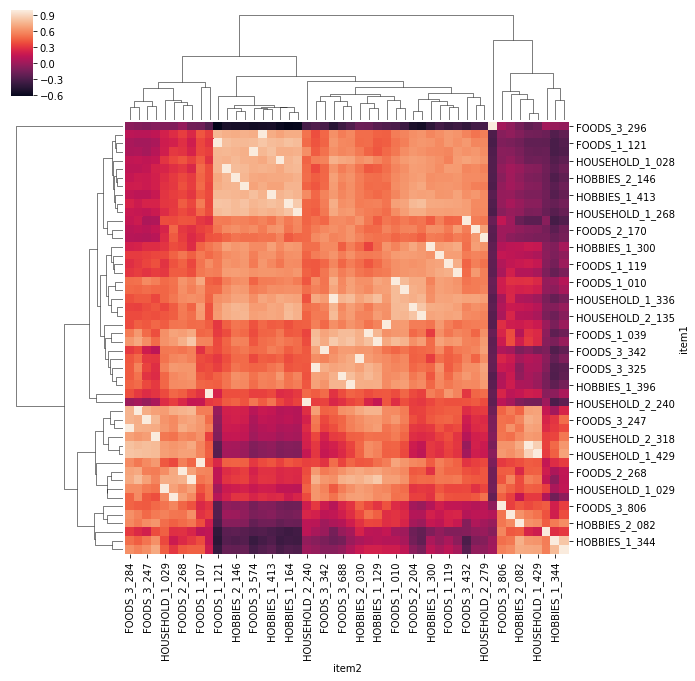

In [47]:
#plot a similarity matrix
import seaborn as sns
sns.clustermap(1-dtw_diff_df)

In [48]:
#ward clustering from difference matrix
t=ward(dtw_diff_df)
#extract clusters
dtw_clusters=pd.DataFrame({'cluster':fcluster(t,1.15)},index=dtw_diff_df.index)

Text(0.5, 1.0, 'Frequency of DTW clusters')

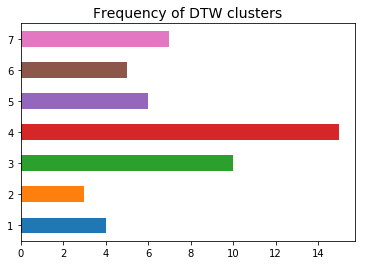

In [50]:
dtw_clusters.cluster.value_counts().sort_index().plot.barh()
plt.title('Frequency of DTW clusters', fontsize=14)

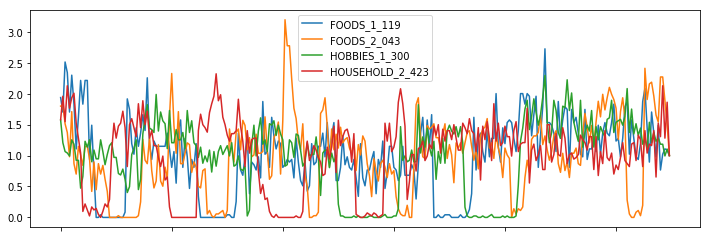

In [55]:
#Cluster 1
daily_sales_item_lookup_scaled_weekly.T.merge(dtw_clusters.loc[dtw_clusters.cluster==1],left_index =True,right_index=True).T.plot(figsize=(12,4))
#The series have intermittent of no sales,. followed by periods of stable sales. 

In [56]:
#show the series pair-wise
def plot_dtw(series1:str, series2:str)->None:
    dtw(daily_sales_item_lookup_scaled_weekly[series1],daily_sales_item_lookup_scaled_weekly[series2],keep_internals=True, step_pattern=rabinerJuangStepPattern(2,'c')).plot(type='twoway',offset=5)

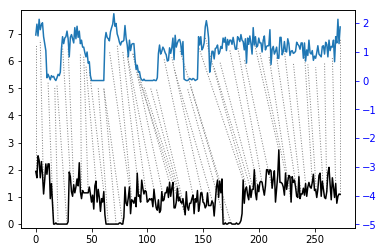

In [57]:
plot_dtw('FOODS_1_119','HOUSEHOLD_2_423')
#We observe that periods of no sales are aligned between, and periods with stable sales are aligned as well.